# Wstęp
Zadanie 6 stanowi wprowadzenie w tematykę *data augmentation*. Ze względu na złożonośc modeli głębokich, zwykle wymagają one bardzo dużych zbiorów danych do dobrego wyuczenia. Jednym ze sposobów na skalowanie ilości dostępnych danych są metody tzw. augmentacji - przekształcenia na danych które mamy, aby utworzyć nowe przykłady o znanych etykietach. Pod koniec zadania wprowadzona jest również koncepcja *skip connections*, będących istotnym elementem współczesnych architektur konwolucyjnych i nie tylko.

#Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    koncepcją augmentacji danych
*    implementacją metod augmentacji danych obrazowych w torch.transforms
*    koncepcją augmentacji niezależnej od dziedziny
*    modelami sieci głębokich ze skip connections

#Augmentacja danych obrazowych

W pierwszej kolejności zapoznajmy się z funkcjonalnością augmentacji danych obrazowych. W pytorch funkcjonalność ta realizowana jest przez transformacje wykonywane na obrazach przez `torchvision.transforms`.

Transformacje które typowo wykorzystuje się w augmentacji to standardowe przekształcenia afiniczne obrazu - rotacje, dobicia, skalowanie. Oczywiście, pownniśmy dobierać transformacje z takich, po których rzeczywiście oczekujemy inwariancji - przekształcony obraz będziemy podawać do sieci z tą samą etykietą. Przykładowo, na zbiorze odręcznie pisanych cyfr MNIST ograniczymy zakres obrotów czy wykorzystanie odbicia w osi poziomej, jako że niechcemy pomylić 5 z 2 czy 6 z 9.

Zapoznaj się z dokumentacją transforms tutaj:

https://pytorch.org/vision/stable/transforms.html

Kod poniżej wczytuje CIFAR 10 i pokazuje wyniki przykładowej augmentacji - losowej rotacji o kąt -30 do 30 stopni.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose([transforms.RandomRotation(30), transforms.ToTensor()])

train_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, download=True
)
img, label = train_ds[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

img, label = train_ds[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

Widzimy tutaj kolejny potencjalny problem z augmentacjami: ze względu na konieczność utrzymania stałego kształtu wejścia, augmentacje mogą wprowadzać artefakty takie jak czarne fragmenty na krawędziach obrazu czy aliasing wynikający z niskiej rozdzielczości.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, download=True
)
test_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, train=False, download=True
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)


def count_correct(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()


def validate(
    model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss, dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all


def fit(
    model: nn.Module,
    optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    epochs: int,
    print_metrics: bool = True,
):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    last_loss = float("inf")
    no_improvement_count = 0

    for epoch in range(epochs):
        if no_improvement_count >= 5:
            return (train_losses, train_accs, val_losses, val_accs)
        for X_batch, y_batch in tqdm(train_dl):
            y_pred = model(X_batch.cuda())
            loss = loss_fn(y_pred, y_batch.cuda())

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()


        model.eval()
        with torch.no_grad():
            train_loss, train_acc = validate(
                model=model, loss_fn=loss_fn, dataloader=train_dl
            )
            val_loss, val_acc = validate(
                model=model, loss_fn=loss_fn, dataloader=val_dl
            )
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            if last_loss <= train_loss:
                no_improvement_count += 1
                continue

            last_loss = train_loss
            no_improvement_count = 1


            if print_metrics:
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                )

    return (train_losses, train_accs, val_losses, val_accs)

Files already downloaded and verified
Files already downloaded and verified


# Zadanie 1

Wykorzystując klasę ThreeLayerCNN, spróbuj dobrać augmentacje danych tak aby poprawić wyniki względem jej braku na zbiorze CIFAR10.

In [ ]:
class ThreeLayerCNN(torch.nn.Module):
    def __init__(self, channels: int, labels: int):
        super().__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module("conv_1", torch.nn.Conv2d(3, channels, 3, padding=1))
        self.model.add_module("relu_1", torch.nn.ReLU())
        self.model.add_module("max_pool_1", torch.nn.MaxPool2d(2))
        self.model.add_module(
            "conv_2", torch.nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.model.add_module("relu_2", torch.nn.ReLU())
        self.model.add_module("max_pool_2", torch.nn.MaxPool2d(2))
        self.model.add_module(
            "conv3", torch.nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.model.add_module("flatten", torch.nn.Flatten())
        self.model.add_module("linear", torch.nn.Linear(8 * 8 * channels, 10))

    def forward(self, x):
        return self.model(x)

Zaprogramuj eksperyment tak, aby w pętli sprawdzać kolejne potencjalne wersje potoku przetwarzania (różniące się tutaj tylko augmentacją), a na końcu wybrać najlepszą - tak aby możliwe było powtórzenie całego eksperymentu uzasadniającego wybór! Transformacja z augmentacją ma być wywoływana tylko na danych treningowych.

Spróbuj znaleźć również przykład augmentacji pogarszającej wynik w stosunku do bazowego otrzymanego bez augmentacji. Wykorzystaj uczenie na 50 epok i optymalizator Adam z domyślnymi parametrami, bez regularyzacji.

In [ ]:
# zaprojektuj eksperyment sprawdzający kilka możliwych podejść do augmentacji, wybranych z dokumentacji torchvision.transforms
import torchvision.transforms as transforms

augmentation_strategies = [
    ("no_augmentation", transforms.Compose([transforms.ToTensor()])),
    (
        "random_horizontal_flip",
        transforms.Compose(
            [transforms.RandomHorizontalFlip(), transforms.ToTensor()]
        ),
    ),
    (
        "random_rotation",
        transforms.Compose(
            [transforms.RandomRotation(20), transforms.ToTensor()]
        ),
    ),
    (
        "random_crop",
        transforms.Compose(
            [transforms.RandomCrop(32, padding=4), transforms.ToTensor()]
        ),
    ),
    (
        "random_affine",
        transforms.Compose(
            [transforms.RandomAffine(20, translate=(0.1, 0.1)), transforms.ToTensor()]
        ),
    ),
]

In [ ]:
best_val_acc = -float("inf")
best_augmentation = ""

worst_val_acc = float("inf")
worst_augmentation = ""

results = []

for name, augmentation in augmentation_strategies:
    print(f"Training model with {name} augmentation...")
    train_ds = torchvision.datasets.CIFAR10(
        "cifar_root", transform=augmentation, download=True
    )
    train_dl = DataLoader(
        train_ds, batch_size=32, shuffle=True, pin_memory=True
    )

    model = ThreeLayerCNN(32, 10).cuda()
    optimiser = optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    train_losses, train_accs, val_losses, val_accs = fit(
        model,
        optimiser,
        loss_fn,
        train_dl,
        test_dl,
        epochs=50,
        print_metrics=False,
    )

    model.eval()
    with torch.no_grad():
        _, val_acc = validate(model, loss_fn, test_dl)

    print(f"{name} augmentation: validation accuracy = {val_acc:.3f}")

    results.append((name, train_losses, train_accs, val_losses, val_accs))

    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_augmentation = name

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_augmentation = name

print(f"Best augmentation strategy: {best_augmentation} (accuracy: {best_val_acc:.3f})")
print(f"Worst augmentation strategy: {worst_augmentation} (accuracy: {worst_val_acc:.3f})")

Training model with no_augmentation augmentation...
Files already downloaded and verified


100%|██████████| 1563/1563 [00:11<00:00, 140.34it/s]


no_augmentation augmentation: validation accuracy = 0.673
Training model with random_horizontal_flip augmentation...
Files already downloaded and verified


100%|██████████| 1563/1563 [00:13<00:00, 115.55it/s]


random_horizontal_flip augmentation: validation accuracy = 0.711
Training model with random_rotation augmentation...
Files already downloaded and verified


100%|██████████| 1563/1563 [00:16<00:00, 97.50it/s]


random_rotation augmentation: validation accuracy = 0.711
Training model with random_crop augmentation...
Files already downloaded and verified


100%|██████████| 1563/1563 [00:15<00:00, 97.86it/s] 


random_crop augmentation: validation accuracy = 0.727
Training model with random_affine augmentation...
Files already downloaded and verified


100%|██████████| 1563/1563 [00:16<00:00, 93.14it/s]


random_affine augmentation: validation accuracy = 0.704
Best augmentation strategy: random_crop (accuracy: 0.727)
Worst augmentation strategy: no_augmentation (accuracy: 0.673)


# Mixup - augmentacja ogólna

Augmentacja daje nam spore możliwości w sytuacji, gdy w dziedzinie danych jesteśmy w stanie wskazać przekształcenia na kóre nasz model powinien być **inwariantny** - dla obrazków niewielkie skalowanie czy przesunięcie nie powinno zmieniać wyniku, zaś dla tekstu, podstawianie synonimów może spełniać podobną rolę. Ale w augmentacji danych możliwe jest też podejście niezależne od typu danych, wynikające z obserwacji dotyczących dynamiki uczenia sieci głębokich w ogóle. Ciekawym przykładem jest tu augmentacja Mixup:

https://arxiv.org/abs/1710.09412

Zasada działania mixup jest niezwykle prosta - generujemy nowe przykłady jako **kombinacje liniowe** tych istniejących w zbiorze danych i oczekujemy, że ich etykiety również będą kombinacjami liniowymi etykiet. Innymi słowy, dla pary przykładów z etykietami: $(x_1, y_1)$, $(x_2, y_2)$, możemy wygenerować przykład $(x', y')$:

$x' = \lambda x_1 + (1-\lambda) x_2$

$y' = \lambda y_1 + (1-\lambda) y_2$

Wartość $\lambda$ jest tutaj losowana z rozkładu Beta - animacja podana na https://en.wikipedia.org/wiki/Beta_distribution#Definitions dobrze obrazuje, jak wygląda ten rozkład dla różnych parametryzacji.

# Zadanie 2

Zmodyfikuj funkcję fit tak, aby uczyć zgodnie z podanym wyżej sformułowaniem augmentacji Mixup. Uwaga: będzie to wymagało modyfikacji funkcji kosztu!

In [ ]:
import numpy as np
from torch.distributions.beta import Beta
from typing import Tuple

def mixup_data(
    x: torch.Tensor, 
    y: torch.Tensor, 
    alpha: float = 1.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]:
    if alpha > 0:
        lam = Beta(alpha, alpha).sample().item()
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(
    criterion: nn.Module, 
    pred: torch.Tensor, 
    y_a: torch.Tensor,
    y_b: torch.Tensor, 
    lam: float
) -> torch.Tensor:
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def fit(
    model: nn.Module,
    optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    epochs: int,
    print_metrics: bool = True,
    alpha: float = 0.4
):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    last_loss = float("inf")
    no_improvement_count = 0

    for epoch in range(epochs):
        if no_improvement_count >= 5:
            return (train_losses, train_accs, val_losses, val_accs)
        for X_batch, y_batch in tqdm(train_dl):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            X_mix, y_a, y_b, lam = mixup_data(X_batch, y_batch, alpha)

            y_pred = model(X_mix)
            loss = mixup_criterion(loss_fn, y_pred, y_a, y_b, lam)


            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        model.eval()
        with torch.no_grad():
            train_loss, train_acc = validate(
                model=model, loss_fn=loss_fn, dataloader=train_dl
            )
            val_loss, val_acc = validate(
                model=model, loss_fn=loss_fn, dataloader=val_dl
            )
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            if last_loss <= train_loss:
                no_improvement_count += 1
                continue

            last_loss = train_loss
            no_improvement_count = 1


            if print_metrics:
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                )

    return (train_losses, train_accs, val_losses, val_accs)

Sprawdź, czy uzyskuje ona przewagę nad modelem trenowanym bez augmentacji. 



In [ ]:
train_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transforms.Compose([transforms.ToTensor()]), download=True
)
train_dl = DataLoader(
    train_ds, batch_size=32, shuffle=True, pin_memory=True
)

model = ThreeLayerCNN(32, 10).cuda()
optimiser = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

mixin_train_losses, mixin_train_accs, mixin_val_losses, mixin_val_accs = fit(
    model,
    optimiser,
    loss_fn,
    train_dl,
    test_dl,
    epochs=50,
    print_metrics=True,
)

model.eval()
with torch.no_grad():
    _, val_acc = validate(model, loss_fn, test_dl)
    mixin_stategy_acc = val_acc

Files already downloaded and verified


100%|██████████| 1563/1563 [00:19<00:00, 80.10it/s] 


Epoch 0: train loss = 0.040 (acc: 0.552), validation loss = 0.041 (acc: 0.551)


100%|██████████| 1563/1563 [00:13<00:00, 111.88it/s]


Epoch 1: train loss = 0.034 (acc: 0.635), validation loss = 0.035 (acc: 0.623)


100%|██████████| 1563/1563 [00:15<00:00, 100.06it/s]


Epoch 2: train loss = 0.033 (acc: 0.642), validation loss = 0.034 (acc: 0.625)


100%|██████████| 1563/1563 [00:12<00:00, 124.21it/s]


Epoch 3: train loss = 0.030 (acc: 0.665), validation loss = 0.032 (acc: 0.644)


100%|██████████| 1563/1563 [00:11<00:00, 130.96it/s]


Epoch 4: train loss = 0.028 (acc: 0.699), validation loss = 0.031 (acc: 0.672)


100%|██████████| 1563/1563 [00:11<00:00, 130.84it/s]


Epoch 5: train loss = 0.027 (acc: 0.712), validation loss = 0.030 (acc: 0.683)


100%|██████████| 1563/1563 [00:12<00:00, 129.89it/s]


Epoch 6: train loss = 0.026 (acc: 0.719), validation loss = 0.030 (acc: 0.681)


100%|██████████| 1563/1563 [00:11<00:00, 131.89it/s]


Epoch 8: train loss = 0.025 (acc: 0.743), validation loss = 0.029 (acc: 0.696)


100%|██████████| 1563/1563 [00:11<00:00, 131.32it/s]


Epoch 10: train loss = 0.025 (acc: 0.742), validation loss = 0.029 (acc: 0.689)


100%|██████████| 1563/1563 [00:11<00:00, 131.57it/s]


Epoch 11: train loss = 0.024 (acc: 0.753), validation loss = 0.028 (acc: 0.699)


100%|██████████| 1563/1563 [00:11<00:00, 131.25it/s]


Epoch 13: train loss = 0.024 (acc: 0.752), validation loss = 0.029 (acc: 0.695)


100%|██████████| 1563/1563 [00:12<00:00, 129.92it/s]


Epoch 14: train loss = 0.023 (acc: 0.771), validation loss = 0.028 (acc: 0.707)


100%|██████████| 1563/1563 [00:12<00:00, 129.37it/s]


Epoch 17: train loss = 0.022 (acc: 0.769), validation loss = 0.028 (acc: 0.707)


100%|██████████| 1563/1563 [00:12<00:00, 129.40it/s]


Epoch 18: train loss = 0.022 (acc: 0.771), validation loss = 0.028 (acc: 0.699)


100%|██████████| 1563/1563 [00:11<00:00, 130.38it/s]


Epoch 20: train loss = 0.022 (acc: 0.778), validation loss = 0.028 (acc: 0.702)


100%|██████████| 1563/1563 [00:11<00:00, 132.70it/s]


Epoch 24: train loss = 0.021 (acc: 0.788), validation loss = 0.027 (acc: 0.708)


100%|██████████| 1563/1563 [00:12<00:00, 128.07it/s]


In [ ]:
print(f"Mixin strategy (accuracy: {mixin_stategy_acc:.3f})")

Mixin strategy (accuracy: 0.700)


# Skrótowe połączenia

W kontekście sieci konwolucyjnych warto zpoznać się jeszcze z jedną istotną koncepcją: połączenia omijające warstwy, poprzez konkatenacje ich wyniku z wynikami dalszych warstw lub dodawanie ich wyniku do wyjścia dalszej warstwy (w drugim przypadku mówimy też o połączeniach *rezydualnych*). Połączenia takie są potrzebne szczególnie przy trenowaniu sieci bardzo głębokich, zawierających dziesiątki czy nawet ponad 100 warstw, czego nie będziemy w stanie realistycznie zrealizować w czasie naszych laboratoriów. Niemniej warto zapoznać się zarówno z samą ideą, jak i ich implementacją, jako że przy pracy z architekturami *state of the art* będziemy często natykać się na takie konstrukcje.

W konstrukcji sieci z połączeniamy pomijającymi warstwy i połączeniami rezydualnymi często będziemy spotykać się z powtarzalnymi *blokami* obejmującymi kilka warstw - dobrą praktyką implementacyjną jest wydzielanie takich bloków jako osobnych podklas `torch.nn.Module`. Warto też z góry zwrócić uwagę, że znane nam już `torch.nn.Sequential` nie uwzględnia połączeń innych niż sekwencyjne - czyli połączenia rezydualne i omijanie warstw nie wchodzi w grę, chyba że w obrębie wydzielonego bloku.

# Zadanie 3

Uzupełnij kod klasy SkipBlock tak, aby implementowała blok o zadanej strukturze.

Struktura SkipBlock:

główna sekwencja warstw

*   warstwa konwolucyjna, nie zmieniająca wymiarów szerokość/wysokość, `in_channels x out_channels`, filtr 3x3
*   aktywacja ReLU
*   warstwa konwolucyjna, wykonująca downsampling x2 w wymiarach szerokość/wysokość, filtr 3x3

warstwa poboczna (na wejściu: wejście do całego bloku, wyjście dodawane jest do wyjścia sekwencji powyżej)

*    warstwa konwolucyjna, filtr 2x2

**Samodzielnie dobierz niesprecyzowane parametry** tak, aby wymiary odpowiednich wyjść się zgadzały. Wyjście bloku powinno mieć `out_channels` kanałów oraz dwukrotnie zmniejszoną wysokość i szerokość w stosunku do wejścia.

In [ ]:
from typing import List

class SkipBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        )
        self.shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        main_out = self.main(x)
        shortcut_out = self.shortcut(x)
        return main_out + shortcut_out


class SkipBlockCNN(torch.nn.Module):
    def __init__(self, channels: List[int], labels: int):
        super().__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module("res_1", SkipBlock(3, channels[0]))
        self.model.add_module("relu_1", torch.nn.ReLU())
        self.model.add_module("res_2", SkipBlock(channels[0], channels[1]))
        self.model.add_module("relu_2", torch.nn.ReLU())
        self.model.add_module("res_3", SkipBlock(channels[1], channels[2]))
        self.model.add_module("relu_3", torch.nn.ReLU())
        self.model.add_module("flatten", torch.nn.Flatten())
        self.model.add_module("linear", torch.nn.Linear(8 * 8 * channels[2], labels))

    def forward(self, x):
        return self.model(x)

 Wyucz sieć SkipBlockCNN i porównaj jej wyniki z wcześniej uzykanymi.

In [ ]:
model = SkipBlockCNN([16, 32, 64], labels=10)

train_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transforms.Compose([transforms.ToTensor()]), download=True
)
train_dl = DataLoader(
    train_ds, batch_size=32, shuffle=True, pin_memory=True
)

model = ThreeLayerCNN(32, 10).cuda()
optimiser = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

skip_train_losses, skip_train_accs, skip_val_losses, skip_val_accs = fit(
    model,
    optimiser,
    loss_fn,
    train_dl,
    test_dl,
    epochs=50,
    print_metrics=True,
)

model.eval()
with torch.no_grad():
    _, val_acc = validate(model, loss_fn, test_dl)

Files already downloaded and verified


100%|██████████| 1563/1563 [00:11<00:00, 131.03it/s]


Epoch 0: train loss = 0.040 (acc: 0.550), validation loss = 0.041 (acc: 0.542)


100%|██████████| 1563/1563 [00:11<00:00, 131.72it/s]


Epoch 1: train loss = 0.035 (acc: 0.607), validation loss = 0.036 (acc: 0.595)


100%|██████████| 1563/1563 [00:12<00:00, 127.86it/s]


Epoch 2: train loss = 0.032 (acc: 0.657), validation loss = 0.033 (acc: 0.642)


100%|██████████| 1563/1563 [00:11<00:00, 130.28it/s]


Epoch 3: train loss = 0.030 (acc: 0.677), validation loss = 0.032 (acc: 0.658)


100%|██████████| 1563/1563 [00:11<00:00, 130.97it/s]


Epoch 5: train loss = 0.028 (acc: 0.693), validation loss = 0.031 (acc: 0.664)


100%|██████████| 1563/1563 [00:12<00:00, 128.00it/s]


Epoch 7: train loss = 0.027 (acc: 0.718), validation loss = 0.030 (acc: 0.676)


100%|██████████| 1563/1563 [00:12<00:00, 129.70it/s]


Epoch 8: train loss = 0.026 (acc: 0.731), validation loss = 0.029 (acc: 0.695)


100%|██████████| 1563/1563 [00:11<00:00, 130.63it/s]


Epoch 9: train loss = 0.026 (acc: 0.730), validation loss = 0.029 (acc: 0.690)


100%|██████████| 1563/1563 [00:12<00:00, 125.75it/s]


Epoch 10: train loss = 0.025 (acc: 0.735), validation loss = 0.029 (acc: 0.692)


100%|██████████| 1563/1563 [00:11<00:00, 130.65it/s]


Epoch 11: train loss = 0.025 (acc: 0.740), validation loss = 0.029 (acc: 0.689)


100%|██████████| 1563/1563 [00:12<00:00, 129.93it/s]


Epoch 13: train loss = 0.024 (acc: 0.751), validation loss = 0.029 (acc: 0.695)


100%|██████████| 1563/1563 [00:11<00:00, 132.41it/s]


Epoch 14: train loss = 0.024 (acc: 0.748), validation loss = 0.028 (acc: 0.691)


100%|██████████| 1563/1563 [00:12<00:00, 128.87it/s]


Epoch 15: train loss = 0.024 (acc: 0.762), validation loss = 0.028 (acc: 0.703)


100%|██████████| 1563/1563 [00:12<00:00, 128.94it/s]


Epoch 16: train loss = 0.023 (acc: 0.758), validation loss = 0.028 (acc: 0.697)


100%|██████████| 1563/1563 [00:11<00:00, 131.18it/s]


Epoch 18: train loss = 0.023 (acc: 0.763), validation loss = 0.028 (acc: 0.698)


100%|██████████| 1563/1563 [00:11<00:00, 132.96it/s]


Epoch 19: train loss = 0.022 (acc: 0.774), validation loss = 0.028 (acc: 0.701)


100%|██████████| 1563/1563 [00:12<00:00, 129.50it/s]


Epoch 20: train loss = 0.022 (acc: 0.773), validation loss = 0.027 (acc: 0.706)


100%|██████████| 1563/1563 [00:14<00:00, 106.17it/s]


In [ ]:
print(f"SkipBlock strategy (accuracy: {val_acc:.3f})")

SkipBlock strategy (accuracy: 0.695)


In [41]:
def plot_scores(scores_list: list[tuple[list[torch.Tensor], str]]):
    plt.figure(figsize=(10, 6))
    lines = []
    for score, label in scores_list:
        (line,) = plt.plot([tensor.cpu() for tensor in score], label=label)
        lines.append(line)
    plt.title("accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("score")
    plt.legend(lines, [l.get_label() for l in lines], loc="best")
    plt.show()

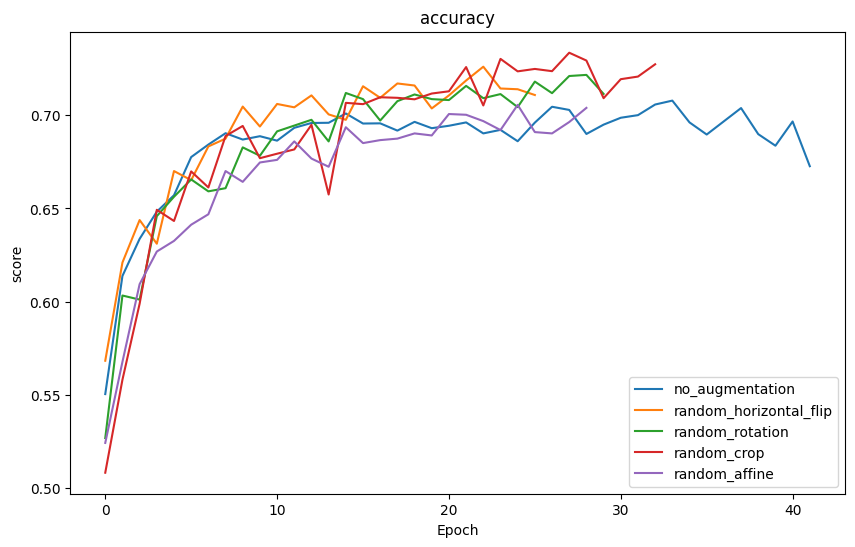

In [42]:
scores_final = [(results[0][4], results[0][0]), (results[1][4], results[1][0]),(results[2][4], results[2][0]),(results[3][4], results[3][0]),(results[4][4], results[4][0])]

plot_scores(scores_final)

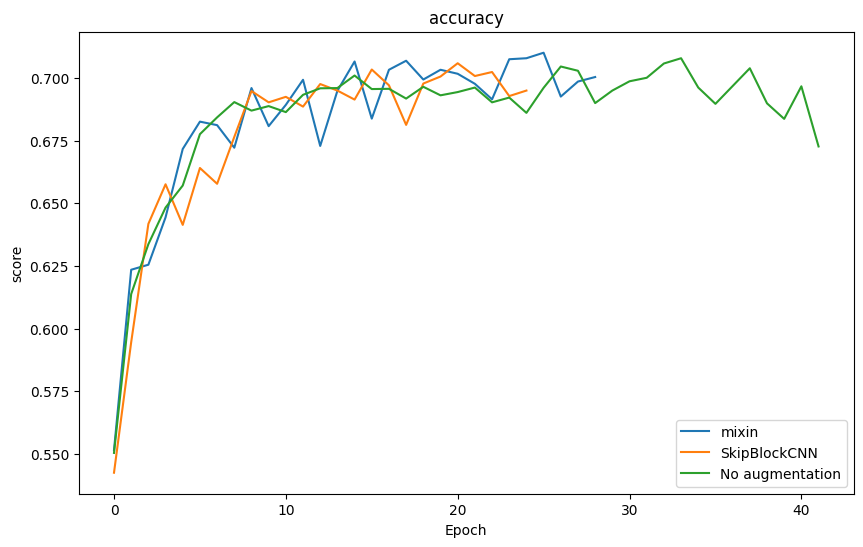

In [43]:
scores_final = [(mixin_val_accs, "mixin"), (skip_val_accs, "SkipBlockCNN"), (results[0][4], "No augmentation")]

plot_scores(scores_final)